In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
wavenumber = 0.4
h = 0.05

In [3]:
two_branches = bempp.api.import_grid('2branches.msh')
space_two_branches = bempp.api.function_space(two_branches,'P',1)

In [4]:
unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

In [5]:
mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere,space_unit_sphere,space_unit_sphere).weak_form().A

In [7]:
mass_mat.shape

(6297, 6297)

In [46]:
eta = wavenumber

identity2 = bempp.api.operators.boundary.sparse.identity(space_two_branches, space_two_branches,space_two_branches)
slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
slp_far2 = helmholtz_farfield.single_layer(space_two_branches, vert_unit_sphere, wavenumber)
dlp_far2 = helmholtz_farfield.double_layer(space_two_branches, vert_unit_sphere,wavenumber)

lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

In [27]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]

def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)/(-1)**(abs(p))
    return coeff

def sca_far_field(x):
    fun = 0
    i = 0
    for q in range(deg+1):
        for p in range(-q,q+1):
            fun += coeff_sca[i]*(1/wavenumber)*(-1j)**(q+1) * normalized_spherical_harmonics(p, q, x)
            i +=1
    return fun

In [47]:
for deg in [5,10,15]:
    sph_harm_coeff = []
    slp_far_field_coeff = []
    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def sph_harm(x,n,domain_index,result):
                with objmode():
                    result[0] = normalized_spherical_harmonics(p,q,x)
            sph_harm_grid = bempp.api.GridFunction(space_unit_sphere,fun = sph_harm)
            sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun = bempp.api.GridFunction(space_two_branches, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs2, rhs_fun, tol=1E-5)
            slp_far_field_coeff.append(dlp_far2.evaluate(field) - 1j * eta * slp_far2.evaluate(field))

    mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere,space_unit_sphere,space_unit_sphere).weak_form().A

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    coeff_inc = []
    for q in range(deg+1):
        for p in range(-q, q+1):
            coeff_inc.append(coeff_sph_expansion(p,q))

    coeff_sca = T_matrix @ coeff_inc

    far_list_test = []
    for i in range(vert_unit_sphere.shape[1]):
        far_list_test.append(sca_far_field(vert_unit_sphere[:,i]))

    @bempp.api.complex_callable
    def exact_data(x, n, domain_index, result):
        with objmode():
            result[0] = - np.exp(1j * wavenumber * (x[0]*d[0]+x[1]*d[1]+x[2]*d[2]))

    grid_fun = bempp.api.GridFunction(space_two_branches, fun=exact_data)
    fun_exact, info_exact = bempp.api.linalg.gmres(lhs2, grid_fun, tol=1E-5)
    res_exact = dlp_far2.evaluate(fun_exact) - 1j * eta * slp_far2.evaluate(fun_exact)
    err = np.sqrt((far_list_test - res_exact[0,:]) @ mass_mat @ np.conj(far_list_test - res_exact[0,:]))/np.sqrt(res_exact[0,:]@ mass_mat @ np.conj(res_exact[0,:]))

    print(deg,err)

5 (0.00015588552792557376+6.710007007395648e-22j)
10 (0.0001561685337717293-5.456555124075821e-22j)
15 (0.00015655120740610236-2.9694049979408596e-21j)


In [ ]:
#direction is d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
0.2 5 (0.007351923435187111+2.3590972205251136e-20j)
0.2 10 (0.007367122387670303+3.693194825379269e-20j)
0.2 15 (0.0073630871792327+2.3626794609797075e-20j)

0.1 5 (0.0016179111799265059+0j)
0.1 10 (0.0016194314815106035+0j)
0.1 15 (0.0016216814348588705-1.5007912962150346e-20j)

0.05 5 (0.00015588552792557376+6.710007007395648e-22j)
0.05 10 (0.0001561685337717293-5.456555124075821e-22j)
0.05 15 (0.17485176806700486+9.678607065653424e-19j)

In [ ]:
#direction is d = [0,0,1]

0.2 5 (0.008703785970348963+0j)
0.2 10 (0.008714334283577136+0j)
0.2 15 (0.008708031276907172+0j)
0.2 20 (0.008688454544813963+0j)

0.1 5 (0.002988331777867179+3.414235908635529e-20j)
0.1 10 (0.0029890902834077172+0j)
0.1 15 (0.002990049837510448+1.706137057468883e-20j)

0.05 5 (0.001509693142355568-3.5874582193980786e-21j)
0.05 10 (0.0015097210979036887+6.299563021643765e-22j)
0.05 15 (0.001509755813447563-5.695870895845743e-21j)

In [ ]:
#direction is d = [1,0,0]

0.2 5 (0.008107593611668065-1.0166993023242574e-19j)
0.2 10 (0.008120242971940589-7.571993336571069e-21j)
0.2 15 (0.008114996315747306-1.0176276078651083e-19j)
0.2 20 (0.00809579189085443-6.98069899997585e-21j)

0.1 5 (0.0023785082319358153-1.9994253763001012e-20j)
0.1 10 (0.002379505994800906-1.9985869869888948e-20j)
0.1 15 (0.00238086194864934+0j)
0.1 20 (0.0023812408005103904+0j)

0.05 5 (0.0008751305300336465+2.5904522563827e-23j)
0.05 10 (0.0008751807708337108+1.5285997530597268e-20j)
0.05 15 (0.0008752445458805571+1.3590520310508628e-20j)
0.05 20 (0.0008752915627609611+4.266566562510223e-21j)

In [1]:
x_axis = [5, 10, 15]

#direction is d = [1,0,0]
d1_02 = [0.008107593611668065,0.008120242971940589,0.008114996315747306]
d1_01 = [0.0023785082319358153, 0.002379505994800906, 0.00238086194864934]
d1_005 = [0.0008751305300336465, 0.0008751807708337108, 0.0008752445458805571]

#direction is d = [0,0,1]
d2_02 = [0.008703785970348963, 0.008714334283577136, 0.008708031276907172]
d2_01 = [0.002988331777867179, 0.0029890902834077172, 0.002990049837510448]
d2_005 = [0.001509693142355568, 0.0015097210979036887, 0.001509755813447563]

#direction is d = [1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3)]
d3_02 = [0.007351923435187111, 0.007367122387670303, 0.0073630871792327]
d3_01 = [0.0016179111799265059, 0.0016194314815106035, 0.0016216814348588705]
d3_005 = [0.00015588552792557376, 0.0001561685337717293, 0.00015655120740610236]

<Figure size 432x288 with 0 Axes>

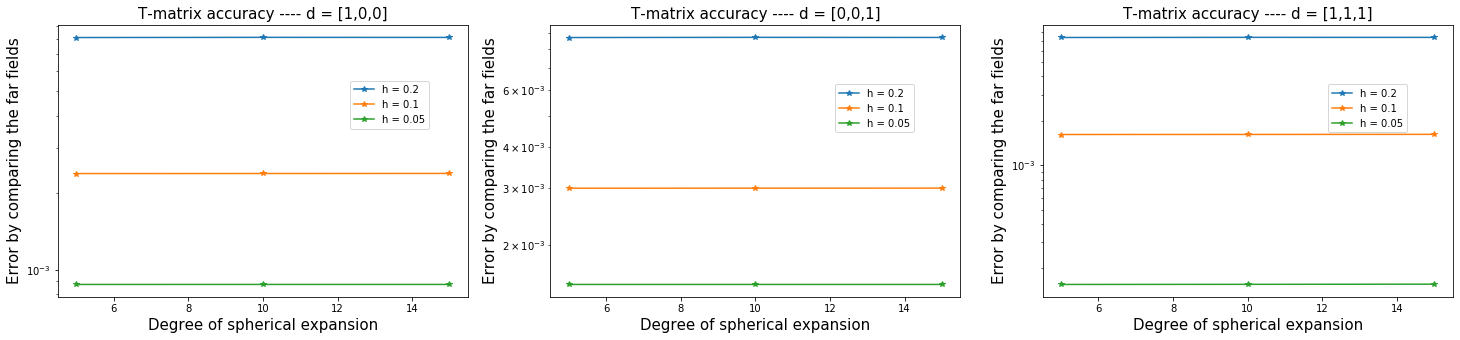

In [52]:
fig = plt.figure()
plt.figure(figsize = (25,5))
plt.subplot(1,3,1)
plt.semilogy(x_axis,d1_02,'*-')
plt.semilogy(x_axis,d1_01,'*-')
plt.semilogy(x_axis,d1_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'],  bbox_to_anchor=(0.7,0.6))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [1,0,0]',fontsize = 15)

plt.subplot(1,3,2)
plt.semilogy(x_axis,d2_02,'*-')
plt.semilogy(x_axis,d2_01,'*-')
plt.semilogy(x_axis,d2_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'], bbox_to_anchor=(0.9,0.8))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [0,0,1]',fontsize = 15)

plt.subplot(1,3,3)
plt.semilogy(x_axis,d3_02,'*-')
plt.semilogy(x_axis,d3_01,'*-')
plt.semilogy(x_axis,d3_005,'*-')
plt.legend(['h = 0.2','h = 0.1','h = 0.05'], bbox_to_anchor=(0.9,0.8))
plt.xlabel('Degree of spherical expansion',fontsize = 15)
plt.ylabel('Error by comparing the far fields',fontsize = 15)
plt.title('T-matrix accuracy ---- d = [1,1,1]',fontsize = 15)
plt.savefig('two branches T matrix accuracy.pdf',bbox_inches='tight')